In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils.class_weight import compute_class_weight
import os
import numpy as np
from sklearn import metrics as mt
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.decomposition import PCA
import pickle
import time
from pandas import DataFrame as df
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [3]:
def unpickle(file):
    #This function turns pickle into dict, file is the file's path.
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='latin1')
    #batch is the dict containing the corresponding batch's data
    return batch


def load_data(path):
    #path is the path of the folder that contains cifar-10 uncompressed data files suitable for python
    #data contains the image data of the batch
    data = []
    #labels contains the corresponding to data labels
    labels = []
    metadata = unpickle(os.path.join(path, 'batches.meta'))
    label_names = metadata['label_names']
    m = metadata['num_vis']
    n = metadata['num_cases_per_batch']
    #loading all 5 batches
    for i in range(1, 6):
        filepath = os.path.join(path, 'data_batch_%d' % i)
        temp = unpickle(filepath)
        data.append(np.reshape(temp['data'], (n, m)))
        labels.append(np.array(temp['labels']))
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    #loading the test data
    temp = unpickle(os.path.join(path, 'test_batch'))
    test_data = np.reshape(temp['data'], (n, m))
    test_labels = np.array(temp['labels'])
    return data, labels, test_data, test_labels, label_names


def train_model(Xs, ys, model_type, svm_param=None, kN=0):
    #Xs and ys are the train set
    #model_type can be either 'NN' or 'nearest_centroid'
    #k is the k parameter (number of neighbours) for the k-NN model
    #svm_param is a dictionary with the necessary parameters of the model
    model_name = ''
    modele = KNeighborsClassifier(n_neighbors=kN, algorithm='brute')
    t = time.time()  #for runtime estimation
    #fitting the model to the train data
    if model_type == 'NN':
        modele = KNeighborsClassifier(n_neighbors=kN, algorithm='brute')
        modele.fit(Xs, ys)
        t = time.time() - t
        model_name = ('%d-NN' % kN)
    elif model_type == 'nearest_centroid':
        modele = NearestCentroid()
        modele.fit(Xs, ys)
        t = time.time() - t
        model_name = 'Nearest Centroid'
    elif model_type == 'svm':
        from sklearn import svm
        if svm_param['kernel'] == 'linear':
            modele = svm.LinearSVC(C=svm_param['C'], dual='auto')
            model_name = 'LSVM (C: %.2e)' % svm_param['C']
        elif svm_param['kernel'] == 'rbf':
            modele = svm.SVC(C=svm_param['C'], kernel='rbf', gamma=svm_param['gamma'])
            model_name = 'SVM (RBF, C: %.2e, gamma: %.2e)' % (svm_param['C'], svm_param['gamma'])
        elif svm_param['kernel'] == 'poly':
            modele = svm.SVC(C=svm_param['C'], degree=svm_param['degree'], gamma=svm_param['gamma'], kernel='poly')
            model_name = 'SVM (polynomial kernel of degree %d (C: %.2e, gamma: %.2e)' % (
                svm_param['degree'], svm_param['C'], svm_param['gamma'])
        elif svm_param['kernel'] == 'sigmoid':
            modele = svm.SVC(C=svm_param['C'], gamma=svm_param['gamma'], kernel='sigmoid')
            model_name = 'SVM (sigmoid, C: %.2e, gamma: %.2e)' % (svm_param['C'], svm_param['gamma'])
        modele.fit(Xs, ys)
        t = time.time() - t
    else:
        print('Wrong model_type input. Acceptable values\nare: "NN" or "nearest_centroid".')
    print('%s:' % model_name)
    print('Training time elapsed: %.2f ms.' % (1000 * t))
    return modele, model_name


def evaluate_model(modele, Xs, ys, model_name, label_names, Xim=None, exnum=5, whoim=None):
    #model is the sklearn classification model object for evaluation
    #Xs ys are the validation or test data
    #model_name is the name of the model
    #Predicting the classes of the test Xs
    t = time.time()  #for calculating prediction time
    y_hat = modele.predict(Xs).astype(int)
    if len(y_hat.shape) > 1:
        y_hat = np.argmax(y_hat, 1)
    t = time.time() - t
    print('Prediction time elapsed: %.2f ms.' % (1000 * t))
    #Calculating recall and precision class wise
    recall = mt.recall_score(ys, y_hat, average=None)
    precision = mt.precision_score(ys, y_hat, average=None)
    # Calculating class wise f1_score
    f1 = 2 * recall * precision / (recall + precision)
    #Calculating average (macro) accuracy of the model
    accu = np.sum(np.equal(ys, y_hat)) / len(ys)  #or just the np.mean(recall)
    print('Accuracy: %.4f' % accu)
    daf = np.vstack((recall, precision))
    daf = np.vstack((daf, f1))
    avrgs = np.zeros((3, 1))
    avrgs[2] = np.mean(f1)
    avrgs[1] = np.mean(precision)
    avrgs[0] = np.mean(recall)
    daf = np.hstack((daf, avrgs))
    label_names = np.hstack((label_names, 'average'))
    daaf = df(data=daf, index=['recall', 'precision', 'f1'], columns=label_names)
    print(daaf.to_string())
    print('\n\n')
    #Calculating and plotting the confusion matrix of the model on the val/test data
    cm = mt.confusion_matrix(ys, y_hat)
    disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names[0:len(label_names) - 1])
    disp.plot()
    plt.title(model_name)
    plt.show()
    print('\n\n')
    #Classification examples exnum x len(label_names) grid of images with their
    #true label and their predicted label. This can be random or half correct 
    #half wrong.
    #If no images where provided for presentation,classification example is
    #demanded and Xim=None (default) it is assumed that a PCA was performed.
    #(with sklearn.decomposition.PCA named pca). If Xim is an array-like variable
    #it is used for the examples. If it's a dictionary an error will occur.
    if hasattr(Xim, "__len__"):
        Xs = Xim
    elif Xim is None:
        Xs = pca.inverse_transform(Xs) * std + mu
        Xs = (Xs - np.min(Xs)) / (np.max(Xs) - np.min(Xs))
        Xs = np.reshape(Xs, (Xs.shape[0], 32, 32, 3))
    images = []
    y_pred = []
    y_true = []
    un_classes = np.unique(ys)
    if whoim == 'half':  #Half correct half wrong examples
        #Inserting a random factor for the images that will be shown as examples.
        random_factor = int(np.random.randint(0, high=int(np.floor(len(Xs) / \
                                                                   len(label_names) - 1)) * np.min(recall) - len(label_names) - exnum,
                                              size=(1,))[0])
        #Calculating the indices for each class.
        for j in range(len(label_names) - 1):
            ind_c = np.array(np.nonzero(np.logical_and(y_hat == ys, un_classes[j] == ys)))
            ind_c = np.reshape(np.transpose(ind_c)[0 + random_factor: \
                                                   random_factor + int(np.ceil(exnum / 2.0))],
                               (int(np.ceil(exnum / 2.0), )))
            ind_f = np.array(np.nonzero(np.logical_and(y_hat != ys, un_classes[j] == ys)))
            ind_f = np.reshape(np.transpose(ind_f)[0 + random_factor: \
                                                   random_factor + int(np.floor(exnum / 2.0))],
                               (int(np.floor(exnum / 2.0))))
            images.append(np.concatenate([Xs[ind_c], Xs[ind_f]]))
            y_pred.append(np.concatenate([y_hat[ind_c], y_hat[ind_f]]))
            y_true.append(np.concatenate([ys[ind_c], ys[ind_f]]))
            #Plotting a grid of examples
        figsize = (len(label_names) - 1, exnum + int(np.ceil(exnum / 2.0)))
        fig, axes = plt.subplots(exnum, len(label_names) - 1, figsize=figsize, tight_layout=True)
        fig.suptitle('Classification Examples ' + model_name)
        for i in range(axes.shape[1]):
            for j in range(axes.shape[0]):
                axes[j, i].imshow(images[i][j])
                axes[j, i].set_xticks([])
                axes[j, i].set_yticks([])
                if j == 0:
                    if y_true[i][j] == -1:
                        axes[j, i].set_title(label_names[0])
                    else:
                        axes[j, i].set_title(label_names[y_true[i][j]])
                if y_true[i][j] == y_pred[i][j]:
                    if y_pred[i][j] == -1:
                        axes[j, i].set_xlabel(label_names[0], c='g')
                    else:
                        axes[j, i].set_xlabel(label_names[y_pred[i][j]], c='g')
                else:
                    if y_pred[i][j] == -1:
                        axes[j, i].set_xlabel(label_names[0], c='r')
                    else:
                        axes[j, i].set_xlabel(label_names[y_pred[i][j]], c='r')
        plt.show()
        print('\n\n')
    elif whoim == 'rand':  #Random examples 
        random_factor = int(np.random.randint(0, high=int(np.floor(len(Xs) / \
                                                                   len(label_names) - 1)) - len(label_names) - exnum, size=(1,))[0])
        for j in range(len(label_names) - 1):
            ind = np.array(np.nonzero(un_classes[j] == ys))
            ind = np.reshape(np.transpose(ind)[random_factor: \
                                               (random_factor + exnum)], (exnum,))
            images.append(Xs[ind])
            y_pred.append(y_hat[ind])
            y_true.append(ys[ind])
        figsize = (len(label_names) - 1, exnum + int(np.ceil(exnum / 2.0)))
        fig, axes = plt.subplots(exnum, len(label_names) - 1, figsize=figsize, tight_layout=True)
        fig.suptitle('Classification Examples ' + model_name)
        for i in range(axes.shape[1]):
            for j in range(axes.shape[0]):
                axes[j, i].imshow(images[i][j])
                axes[j, i].set_xticks([])
                axes[j, i].set_yticks([])
                if j == 0:
                    if y_true[i][j] == -1:
                        axes[j, i].set_title(label_names[0])
                    else:
                        axes[j, i].set_title(label_names[y_true[i][j]])
                if y_true[i][j] == y_pred[i][j]:
                    if y_pred[i][j] == -1:
                        axes[j, i].set_xlabel(label_names[0], c='g')
                    else:
                        axes[j, i].set_xlabel(label_names[y_pred[i][j]], c='g')
                else:
                    if y_pred[i][j] == -1:
                        axes[j, i].set_xlabel(label_names[0], c='r')
                    else:
                        axes[j, i].set_xlabel(label_names[y_pred[i][j]], c='r')
        plt.show()
        # print('\n\n')
    return recall, precision, f1


def choose_k(features, kstart=2, kstop=20, kstep=1):
    #Function to visualize the moment and the silhouette score for different number of centers with k-means
    Krange = np.arange(start=kstart, stop=kstop, step=kstep)
    silhouettescores = []
    distortion = []
    for kval in Krange:
        means = KMeans(n_clusters=kval, random_state=73, n_init=1)
        print('k = %d starting...' % kval, end='')
        means.fit(features)
        print('fitted.\n')
        distortion.append(means.inertia_)
        silhouettescores.append(silhouette_score(features, means.labels_))

    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(Krange, distortion, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(Krange, silhouettescores, marker='o')
    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()


class RBFLayer:
    ## Class of the RBF Hidden Layer with number of centers nodes and one output node
    def __init__(self, centers,normalized = False):
        #centers are the coordinates of the centers for the hidden nodes
        self.centers = centers
        # self.out_shape = (centers.shape[0]+1,) #if we want to add a bias phi
        self.out_shape = (centers.shape[0],)#The output shape of the layer useful if we want just to train the hidden layer and output it to multiple output nodes
        self.weights = np.zeros(self.out_shape)#The weights of each edge connecting the hidden nodes to the output node
        d_max = 0#Calculating the maximum center distance in order to estimate the gamma parameter (Lowe,1989)
        for i in range(self.centers.shape[0]):
            for j in range(i + 1, self.centers.shape[0]):
                d_temp = np.linalg.norm(self.centers[i] - self.centers[j],2)
                if d_temp > d_max:
                    d_max = d_temp
        # self.gamma = 1 / (2 * (d_max / np.sqrt((self.out_shape[0]-1) * 2)) ** 2) #if we want to add a bias phi
        self.gamma = 1 / (2 * (d_max / (np.sqrt((self.out_shape[0]) * 2)) )** 2) #gamma = 1/(2*sigma^2)
        print('Gamma calculated.')
        self.class_weights = []#class weights for unbalanced classes 
        self.normalized = normalized

    def RLSstep(self, inputs):
        #This method unsupervisingly trains the hidden layer on the inputs given the self.centers
        #Its output is the result of the kernel functions on the inputs
        # phi = np.zeros((inputs.shape[0], self.out_shape[0]-1))#if we want to add a bias phi
        phi = np.zeros((inputs.shape[0], self.out_shape[0]))
        if self.normalized:
            for observation in range(inputs.shape[0]):
                phi[observation] = np.exp(-self.gamma * np.sum((inputs[observation] - self.centers) ** 2, 1))#Gaussian 
                phi[observation] = phi[observation]/np.sum(phi[observation])
                print('%d out of %d'%(observation+1,inputs.shape[0]),end='\r')
            print('\nPhis calculated.\n')
            # phi = np.hstack((phi,np.ones((inputs.shape[0],1))))#if we want to add a bias phi
        else:
            for observation in range(inputs.shape[0]):
                phi[observation] = np.exp(-self.gamma * np.sum((inputs[observation] - self.centers) ** 2, 1))#Gaussian 
                print('%d out of %d'%(observation+1,inputs.shape[0]),end='\r')
            print('\n')
            # phi = np.hstack((phi,np.ones((inputs.shape[0],1))))#if we want to add a bias phi
        return phi
        
        
    def fit(self, inputs, ys, xval=None, yval=None, epochs=2, regul=0.01, weighted="balanced",ready=None):
        #This method uses the RLS algorithm to train the weights of the hidden layer nodes
        #It works for binary classification with sign scheme (-1,1)
        #Its result is saved into the self.weights variable in order to be usable for later predictions
        #regul is the regularizer parameter lambda 
        #The ready argument can be used to pass the phi values of theese inputs for the Layer and avoid multiple
        #unecesssary calculations
        #If weighted equals balanced then the inverse frequency weights are used during the training
        N = inputs.shape[0]
        Pn = (1 / regul) * np.eye(self.out_shape[0])#The inverse of the correlation matrix
        if ready is None:
            phis = self.RLSstep(inputs)
        else:
            phis = ready
        if weighted == "balanced":
            self.class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(ys), y=ys)
        else:
            self.class_weights = np.ones((len(np.unique(ys)),))#if not balanced we don't use weights
        for epoch in range(epochs):
            print('Epoch %d out of %d.' % (epoch + 1, epochs))
            for observation in range(N):
                print('%d/%d' % (observation + 1, N), end='\r')
                phi = phis[observation]
                Pn = Pn - (Pn @ np.outer(phi, phi) @ Pn) / (1 + np.expand_dims(phi, 0) @ Pn @ phi)#correlation matrix update
                gn = Pn @ phi#gain vector 
                if ys[observation] == -1:#to add the correct weights BE CAREFUL to use -1,1 binary scheme
                    an = self.class_weights[0] * (ys[observation] - np.expand_dims(self.weights, 0) @ phi)
                else:
                    an = self.class_weights[1] * (ys[observation] - np.expand_dims(self.weights, 0) @ phi)
                # an = ys[observation] - np.expand_dims(self.weights,0)@phi
                self.weights = self.weights + gn * an#weights update
            y_hat = np.sign(np.sum(self.weights * phis, 1))#calculation of train metrics
            loss = (np.sum((ys - y_hat) ** 2) / 2 + regul * np.sum(self.weights ** 2) / 2)/N#mean cost function is the squared error plus the regularization error
            # (MSE+sth)
            acc = 100 * np.sum(y_hat == ys) / len(ys)
            if xval is not None:#We can print the validation set metrics ass well
                y_hat_val = self.predict(xval)
                val_loss = (np.sum((yval - y_hat_val) ** 2) / 2 + regul * np.sum(self.weights ** 2) / 2)/N
                val_acc = 100 * np.sum(y_hat_val == yval) / len(yval)
                print('train loss = %.5f\t train acc = %.2f\tvalidation loss = %.5f\tvalidation acc = %.2f' % (
                loss, acc, val_loss, val_acc))
                print('\n')
            else:
                print('train loss = %.5f\t train acc = %.2f' % (loss, acc))
                print('\n')

    def predict(self, inputs, real=False,ready=None):
        #This method returns the predictions of the RBFLayer, they can be real numbers in order to be used in some multiclass scheme or
        #the binary classification result (the sign)
        if ready is None:
            phis = self.RLSstep(inputs)
        else:
            phis = ready
        if real:
            y_hat = (np.sum(self.weights * phis, 1))
        else:
            y_hat = np.sign(np.sum(self.weights * phis, 1))
        return y_hat
    

class RBFnn:
    #This class is used to either enable different method of the output layer weight training (using a 2 Layer Dense Neural Network)
    #or to enable 4 different multiclass schemes using the binary RBFLayer with RLS or NN weight training at the end.
    def __init__(self, classifier_code, k_centers,way='ovo',normalized = False):
        # self.mul_class = None
        self.rbfnodes = []#The number of RBF output nodes of the Network (remeber RBFLayer by default has one "binary" output node)
        self.c_c = classifier_code#This is an array with rows = number of classes used in OVR and ECC classification modes
        self.K = k_centers#The number of centers for the RBF hidden layer
        self.train_out = None#The output of the hidden layer stored to be used on the traning of the output layer
        self.train_labels = None#The labels of the corresponding train_out
        self.predict_way = way#The mode of the network(OVR,OVO,ECC,NN)
        self.normalized = normalized 
    def fit(self, inputs, ys, xval=None, yval=None,weighted="balanced"):
        self.train_labels = ys
        if self.c_c is not None:
            hidden_layer = KMeans(n_clusters=self.K, random_state=42, n_init=1)
            centers = hidden_layer.fit(inputs)#We use the same centers for all classifiers, this way it is like the hidden RBF Layer is connected to each 
                                              #output node densely. (hidden nodes*out nodes = number of total weights)
            self.train_out = np.zeros((inputs.shape[0], self.c_c.shape[1]))
            first_node = RBFLayer(hidden_layer.cluster_centers_,normalized = self.normalized)
            phiss = first_node.RLSstep(inputs)#Calculating the results of the hidden layer on the input
            for i in range(self.c_c.shape[1]):#The number of binary classifier on the scheme (or output nodes on the layer)
                node = self.c_c[:, i]
                y_temp = ys.copy()
                for j in range(len(node)):#Binarizing the labels according to classifier scheme
                    if node[j] == 1:
                        y_temp[ys == j] = -1
                    else:
                        y_temp[ys == j] = 1
                rbf_node = RBFLayer(hidden_layer.cluster_centers_,normalized = self.normalized)#Initializing the one node output
                print('Fitting %d out of %d' % (i + 1, self.c_c.shape[1]))
                rbf_node.fit(inputs, y_temp, xval, yval, 2,ready=phiss,weighted=weighted)#Calculating its weights using RLS
                self.train_out[:, i] = rbf_node.predict(inputs, True,ready=phiss)#Saving its output
                self.rbfnodes.append(rbf_node)#Saving the output_node/classifier
        else:#If no classifier code is given we assume OVO 
            classes = np.unique(ys)
            n = len(classes)
            self.train_out = np.zeros((inputs.shape[0], int((n * (n - 1)) / 2)))#In case of cifar-10 it is 45 output nodes/binary classifiers
            count = 0  #lazy way
            hidden_layer = KMeans(n_clusters=self.K, random_state=42, n_init=1)
            centers = hidden_layer.fit(inputs)#We use the same centers for all classifiers, this way it is like the hidden RBF Layer is connected to each 
                                              #output node densely. (hidden nodes*out nodes = number of total weights)
            first_node = RBFLayer(hidden_layer.cluster_centers_,normalized = self.normalized)
            phiss = first_node.RLSstep(inputs)#Calculating the results of the hidden layer on the input
            for i in range(n):
                for j in range(i + 1, n):#For each pair of classes train a binary classifier/output node weights using RLS 
                    y_temp = ys.copy()
                    x_temp = inputs.copy()
                    phis_temp = phiss.copy()
                    phis_temp = phis_temp[np.logical_or(y_temp == i, y_temp == j)]
                    x_temp = x_temp[np.logical_or(y_temp == i, y_temp == j)]
                    y_temp = y_temp[np.logical_or(y_temp == i, y_temp == j)]
                    y_temp[y_temp == i] = -1
                    y_temp[y_temp == j] = 1
                    rbf_node = RBFLayer(hidden_layer.cluster_centers_,normalized = self.normalized)
                    print('Fitting %d out of %d' % (count + 1, int((n * (n - 1)) / 2)))
                    rbf_node.fit(x_temp, y_temp, xval, yval, 2,ready=phis_temp,weighted=weighted)
                    self.train_out[:, count] = rbf_node.predict(inputs, True,ready=phiss)#Save its output
                    self.rbfnodes.append(rbf_node)
                    count = count + 1#Counting the nodes

    def predict(self, inputs):
        #This method is used in order to take a decision using a multiclass scheme.
        y_hat_t = np.zeros((inputs.shape[0], len(self.rbfnodes)))
        phiss = self.rbfnodes[0].RLSstep(inputs)#Calculating the output of the hidden layer on the input
        for i in range(len(self.rbfnodes)):
            y_hat_t[:, i] = self.rbfnodes[i].predict(inputs, real=True,ready=phiss)#Calculating the output of each node on the input
        if self.predict_way == "ecc":#Using error correcting classification scheme with soft decision (min Euclidean distance)
            dmin = 1e10
            y_hat = np.zeros((inputs.shape[0], self.c_c.shape[0]))
            for i in range(self.c_c.shape[0]):#Calculating the distance from each class
                y_hat[:, i] = np.sum((y_hat_t - self.c_c[i]) ** 2, 1)
            y_hat = np.argmin(y_hat, axis=1)#Choosing class
        elif self.predict_way == 'ovo':#Using one vs one strategy
            minus1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
                      4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8]#The way they are stored (only works on 10 label class at the moment)
            plus1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 4, 5, 6, 7, 8, 9, 5, 6, 7,
                     8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9]
            y_hat_t = np.sign(y_hat_t)
            for i in range(len(self.rbfnodes)):#Hard voting 
                y_hat_t[y_hat_t[:, i] == 1, i] = plus1[i]
                y_hat_t[y_hat_t[:, i] == -1, i] = minus1[i]
            y_hat = np.zeros((inputs.shape[0],))
            for i in range(inputs.shape[0]):
                y_hat[i] = np.argmax(np.bincount(np.round(y_hat_t[i]).astype(int)))#Voting 
        elif self.predict_way == 'ovr':#One vs rest scheme (classification code is a np.eye(len(np.unique(labels))) matrix)
            y_hat_t = (y_hat_t - np.mean(y_hat_t,0))/np.std(y_hat_t,0)
            y_hat = np.argmin(y_hat_t,1)#Voting (minimum because of how the output nodes are trained)
        elif self.predict_way == 'NN':#Else we train a one layer softmax network to decide on the real outputs of the RBF layer
            pred_model = Sequential()
            pred_model.add(tf.keras.layers.InputLayer(self.train_out.shape[1], ))
            pred_model.add(tf.keras.layers.Dense(500,kernel_initializer='glorot_normal',activation='tanh'))
            pred_model.add(tf.keras.layers.Dense(10, activation='softmax'))
            pred_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            hist = pred_model.fit(self.train_out, tf.one_hot(self.train_labels, 10), 50, 50,verbose=1)
            y_hat = np.argmax(pred_model.predict(y_hat_t),1)
        else:
            y_hat = y_hat_t
        return y_hat
    
    
class binary_model:
    def __init__(self,num_of_centers,way='kmeans',normalized=True,lambda_par = 0.25):
        self.center_way = way
        self.centers = []
        self.num_of_centers = num_of_centers#number of rb functions
        self.normalized = normalized
        self.lambda_par = lambda_par
        self.rbf = []
    
    def fit(self,inputs,ys,xval=None,yval=None):
        if self.center_way == 'kmeans':#we use kmeans to determine the centers of the rbfs
            kmt = KMeans(n_clusters=self.num_of_centers,random_state=73,n_init=1)
            kmt.fit(inputs)
            self.centers = kmt.cluster_centers_
        else:#Use random samples as centers (equal from each class)
            minus_S = inputs[ys==-1].copy()
            plus_S = inputs[ys==1].copy()
            minus_S = np.random.permutation(minus_S)
            plus_S = np.random.permutation(plus_S)
            minus_S = minus_S[0:np.floor(self.num_of_centers/2)]
            plus_S = plus_S[0:np.ceil(self.num_of_centers/2)]
            self.centers = np.vstack((minus_S,plus_S))
        print('Centers Calculated')
        self.rbf = RBFLayer(self.centers,normalized=self.normalized)
        self.rbf.fit(inputs,ys,xval,yval,epochs=5,regul = self.lambda_par)
    
    def predict(self,inputs):
        return self.rbf.predict(inputs)
        
        
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

my_path = 'C:/cifar10'  #Change this to the path where your cifar-10 data is stored or keep it '' in order to download them.


In [4]:
if my_path == '':
    from keras.datasets import cifar10

    (X, y), (X_test, y_test) = cifar10.load_data()
    label = ['plane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    X = np.reshape(X, (50000, 3072))
    X_test = np.reshape(X_test, (10000, 3072))
    y = np.reshape(y, (50000,))
    y_test = np.reshape(y_test, (10000,))
else:
    X, y, X_test, y_test, label = load_data(my_path)
    label[0] = 'plane'  #for visual purposes
    label[1] = 'auto'
#Z-score scaling of the data for PCA implementation
mu = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_pca = (X - mu) / std
X_test_pca = (X_test - mu) / std
#PCA 
pca = PCA(0.95)
X_pca = pca.fit_transform(X_pca)
X_test_pca = pca.transform(X_test_pca)
if my_path != '':
    X_test = np.transpose(np.reshape(X_test, (10000, 3, 32, 32)), (0, 2, 3, 1))  #for image plotting

##25 binary classification scheme with dmin = 7 
binary_classifiers = np.eye(10)  #np.array([[1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1],
# [1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0],
# [0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1],
# [0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0],
# [0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0],
# [0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1],
# [0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,1,1,0,1],
# [0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0],
# [1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0],
# [1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0]])

In [4]:
# choose_k(X_pca, kstart=2, kstop=100, kstep=5):

In [5]:
# choose_k(X_pca, kstart=2, kstop=40, kstep=1):

In [6]:
# plt.plot(np.arange(start=1, stop=X_pca.shape[1] + 1), np.cumsum(pca.explained_variance_ratio_))
# plt.show

In [7]:
# X_ap = X_pca[np.logical_or(y == 1, y == 0)]
# choose_k(X_ap, kstart=2, kstop=40, kstep=1)

In [5]:
# Xval = X_test_pca.copy()
# Yval = y_test.copy()
# y_ap = y.copy()
# X_ap = X_pca.copy()
# X_dh = X_ap[np.logical_or(y_ap==1,y_ap==9)]
# y_dh = y_ap[np.logical_or(y_ap==1,y_ap==9)]
# X_dht = Xval[np.logical_or(Yval==1,Yval==9)]
# y_dht = Yval[np.logical_or(Yval==1,Yval==9)]
# y_dh[y_dh==1] = -1
# y_dh[y_dh==9] = 1
# y_dht[y_dht==1] = -1
# y_dht[y_dht==9] = 1

In [116]:
# testmodel = RBFnn(np.eye(10), 99,normalized=True,way='ovr')

In [117]:
# testmodel.fit(X_ap, y_ap)

50000 out of 50000
Fitting 1 out of 10
Epoch 1 out of 2.
train loss = 0.48626	 train acc = 75.69


Epoch 2 out of 2.
train loss = 0.47312	 train acc = 76.35

Fitting 2 out of 10
Epoch 1 out of 2.


KeyboardInterrupt: 

10000 out of 10000

Prediction time elapsed: 2542.35 ms.
Accuracy: 0.1000
              plane  auto  bird  cat  deer  dog  frog  horse  ship  truck  average
recall     1.000000   0.0   0.0  0.0   0.0  0.0   0.0    0.0   0.0    0.0     0.10
precision  0.100000   0.0   0.0  0.0   0.0  0.0   0.0    0.0   0.0    0.0     0.01
f1         0.181818   NaN   NaN  NaN   NaN  NaN   NaN    NaN   NaN    NaN      NaN


C:\Users\grist\anaconda3\envs\ml_nn\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\grist\AppData\Local\Temp\ipykernel_13468\4232866925.py:91: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * recall * precision / (recall + precision)


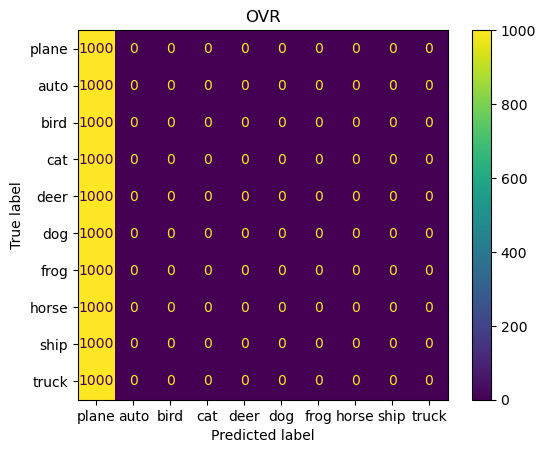

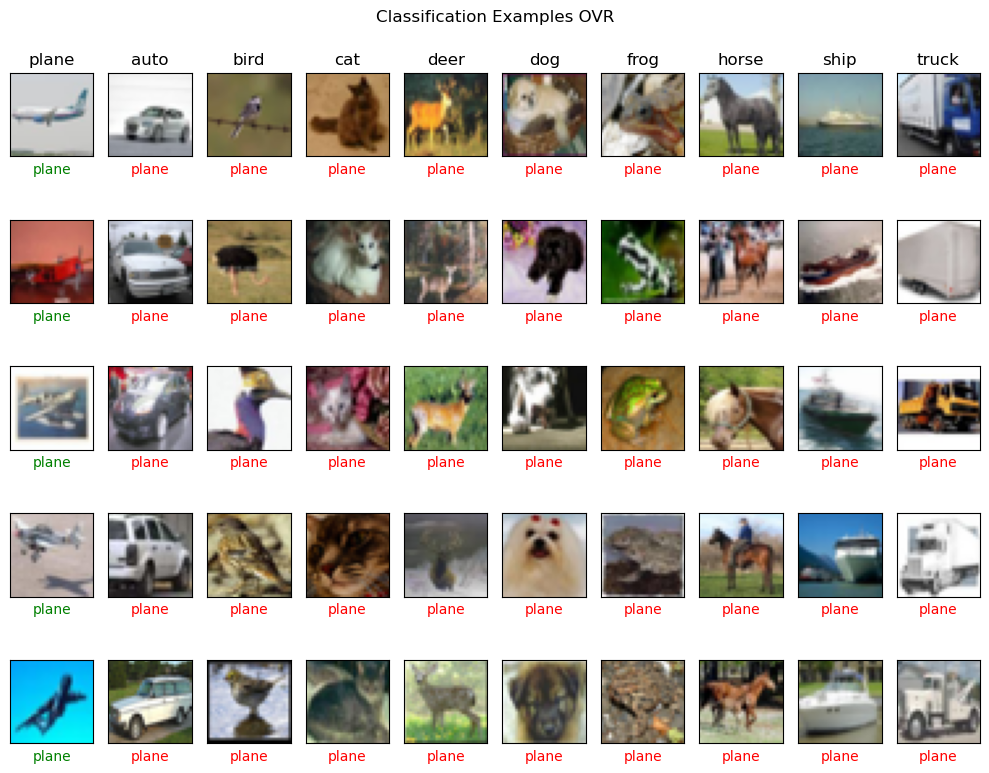

In [118]:
# _,_,_=evaluate_model(testmodel,Xval,Yval, 'OVR', label, Xim=X_test, whoim='rand')

In [137]:
# bm = binary_model(40)
# bm.fit(X_dh,y_dh,X_dht,y_dht)

Centers Calculated
Gamma calculated.
10000 out of 10000
Phis calculated.

Epoch 1 out of 5.
2000 out of 2000
Phis calculated.

train loss = 0.67907	 train acc = 66.06	validation loss = 0.13527	validation acc = 66.25


Epoch 2 out of 5.
2000 out of 2000
Phis calculated.

train loss = 0.67987	 train acc = 66.02	validation loss = 0.13507	validation acc = 66.30


Epoch 3 out of 5.
2000 out of 2000
Phis calculated.

train loss = 0.67967	 train acc = 66.03	validation loss = 0.13507	validation acc = 66.30


Epoch 4 out of 5.
2000 out of 2000
Phis calculated.

train loss = 0.67987	 train acc = 66.02	validation loss = 0.13507	validation acc = 66.30


Epoch 5 out of 5.
2000 out of 2000
Phis calculated.

train loss = 0.67987	 train acc = 66.02	validation loss = 0.13507	validation acc = 66.30


2000 out of 2000
Phis calculated.

Prediction time elapsed: 83.38 ms.
Accuracy: 0.6575
               auto     truck   average
recall     0.639000  0.676000  0.657500
precision  0.663551  0.651880  0.657716
f1         0.651044  0.663721  0.657383


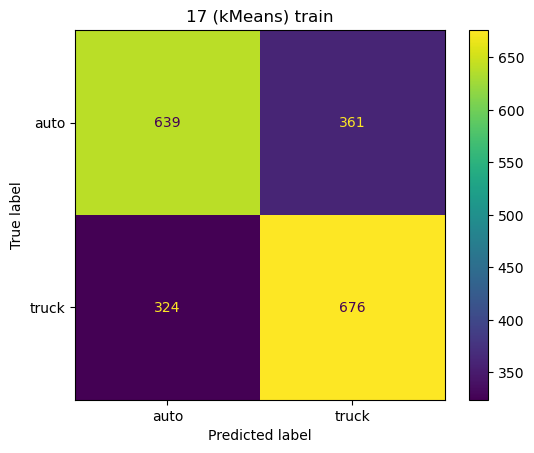

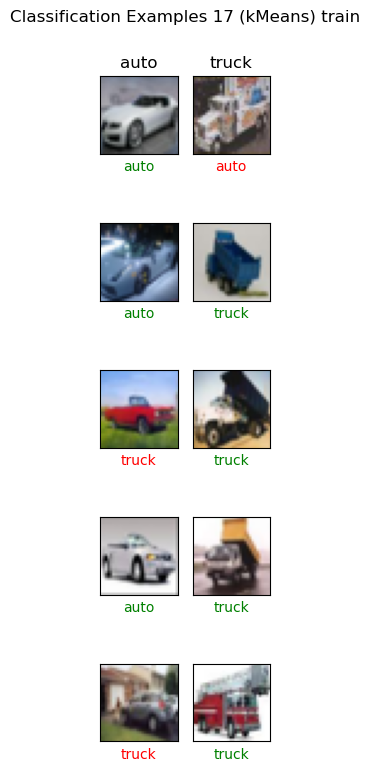

In [136]:
# _,_,_ =evaluate_model(bm,X_dht,y_dht,'17 (kMeans) train',['auto','truck'],X_test[np.logical_or(Yval==1,Yval==9)],whoim='rand')

1-NN:
Training time elapsed: 6.37 ms.
Prediction time elapsed: 222.47 ms.
Accuracy: 0.7000
               auto     truck   average
recall     0.729000  0.671000  0.700000
precision  0.689036  0.712314  0.700675
f1         0.708455  0.691040  0.699747


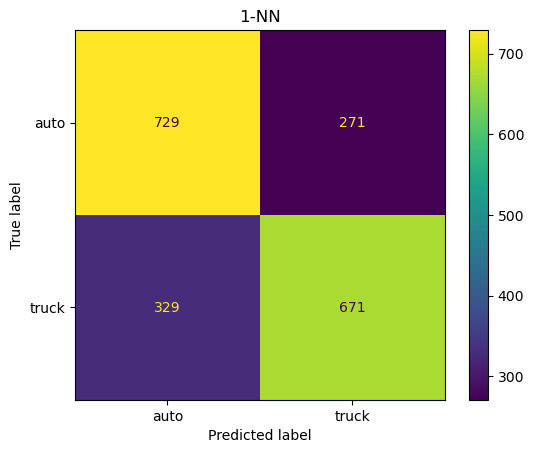

In [231]:
# nn1,nn1_name = train_model(X_dh,y_dh,'NN',kN=1)
# #Evaluating 1-NN on test set
# _,_,_ = evaluate_model(nn1,X_dht,y_dht,nn1_name,['auto','truck'])

In [20]:
# print(np.sum(yh==y_dht)/2000)


In [91]:
# from sklearn.cluster import MiniBatchKMeans
# temp2 = KMeans(n_clusters=1000, random_state=73, n_init=1)
# temp2.fit(X_dh)
# print('Kmean_done')
# rbfl = RBFLayer(temp2.cluster_centers_,normalized=True)
# rbf_out = rbfl.RLSstep(inputs=X_dh)
# print('Layer_done')

Kmean_done
10000 out of 10000

Layer_done


In [92]:
# rbf_out_tensor = tf.convert_to_tensor(rbf_out,dtype=tf.float32)

In [93]:
# phi_val = tf.convert_to_tensor(rbfl.RLSstep(inputs=X_dht),dtype=tf.float32)

2000 out of 2000


In [99]:
# out_layers = Sequential()
# out_layers.add(tf.keras.layers.InputLayer(rbf_out.shape[1], ))
# out_layers.add(tf.keras.layers.Dense(500,kernel_initializer='glorot_normal',activation='tanh'))
# out_layers.add(tf.keras.layers.Dense(2, activation='softmax'))
# out_layers.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
# hist = out_layers.fit(rbf_out_tensor, tf.one_hot(y_dh, 2), 100, 50, validation_data=(phi_val, tf.one_hot(y_dht,2)),
#                       verbose=1)

Epoch 1/50
100/100 [==============================] - 1s 6ms/step - loss: 0.1841 - accuracy: 0.5123 - val_loss: 0.1767 - val_accuracy: 0.5035
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.1753 - accuracy: 0.5276 - val_loss: 0.1779 - val_accuracy: 0.5090
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 0.1760 - accuracy: 0.5352 - val_loss: 0.1787 - val_accuracy: 0.5300
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.1749 - accuracy: 0.5382 - val_loss: 0.1795 - val_accuracy: 0.5220
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.1747 - accuracy: 0.5410 - val_loss: 0.1803 - val_accuracy: 0.5145
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 0.1755 - accuracy: 0.5443 - val_loss: 0.1786 - val_accuracy: 0.5065
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 0.1750 - accuracy: 0.5378 - val_loss: 0.1797 - val_accuracy: 0.5035
Epoch 

In [12]:
# his2 = out_layers.fit(rbf_out_tensor, tf.one_hot(y_ap, 10), 100, 200, validation_data=(phi_val, tf.one_hot(Yval,10)),
#                       verbose=1)

In [13]:
# evaluate_model(out_layers,phi_val,tf.one_hot(Yval,10),'2_LAYER',label)

In [230]:
# ovorbfnn = RBFnn(None,40)
# ovorbfnn.fit(X_ap,y_ap)

50000 out of 50000

Fitting 1 out of 45
Epoch 1 out of 2.
train loss = 6003.95840	 train acc = 70.00


Epoch 2 out of 2.
train loss = 6004.11881	 train acc = 70.00


Fitting 2 out of 45
Epoch 1 out of 2.
train loss = 4589.83800	 train acc = 77.07


Epoch 2 out of 2.
train loss = 4589.90709	 train acc = 77.07


Fitting 3 out of 45
Epoch 1 out of 2.
train loss = 4102.35835	 train acc = 79.51


Epoch 2 out of 2.
train loss = 4104.42300	 train acc = 79.50


Fitting 4 out of 45
Epoch 1 out of 2.
train loss = 3744.09039	 train acc = 81.29


Epoch 2 out of 2.
train loss = 3744.11810	 train acc = 81.29


Fitting 5 out of 45
Epoch 1 out of 2.
train loss = 3818.32126	 train acc = 80.93


Epoch 2 out of 2.
train loss = 3818.38416	 train acc = 80.93

Fitting 6 out of 45
Epoch 1 out of 2.
train loss = 3129.30770	 train acc = 84.37


Epoch 2 out of 2.
train loss = 3127.35343	 train acc = 84.38


Fitting 7 out of 45
Epoch 1 out of 2.
train loss = 4276.14917	 train acc = 78.64


Epoch 2 out of 2.
trai

10000 out of 10000
Prediction time elapsed: 728.97 ms.
Accuracy: 0.3089
              plane      auto      bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.395000  0.127000  0.225000  0.169000  0.386000  0.232000  0.449000  0.198000  0.590000  0.318000  0.308900
precision  0.419766  0.396875  0.224551  0.247438  0.253947  0.380328  0.258492  0.356757  0.332207  0.371495  0.324186
f1         0.407007  0.192424  0.224775  0.200832  0.306349  0.288199  0.328096  0.254662  0.425072  0.342672  0.297009


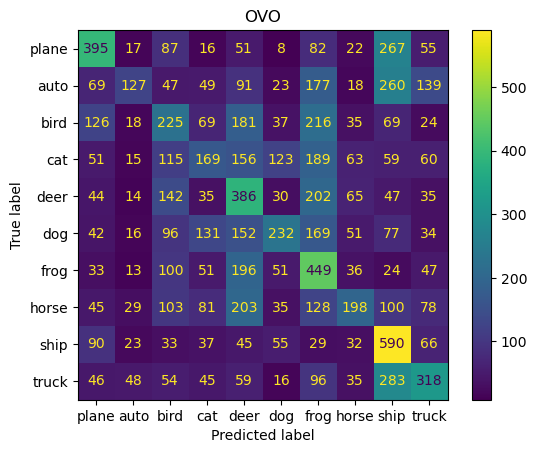

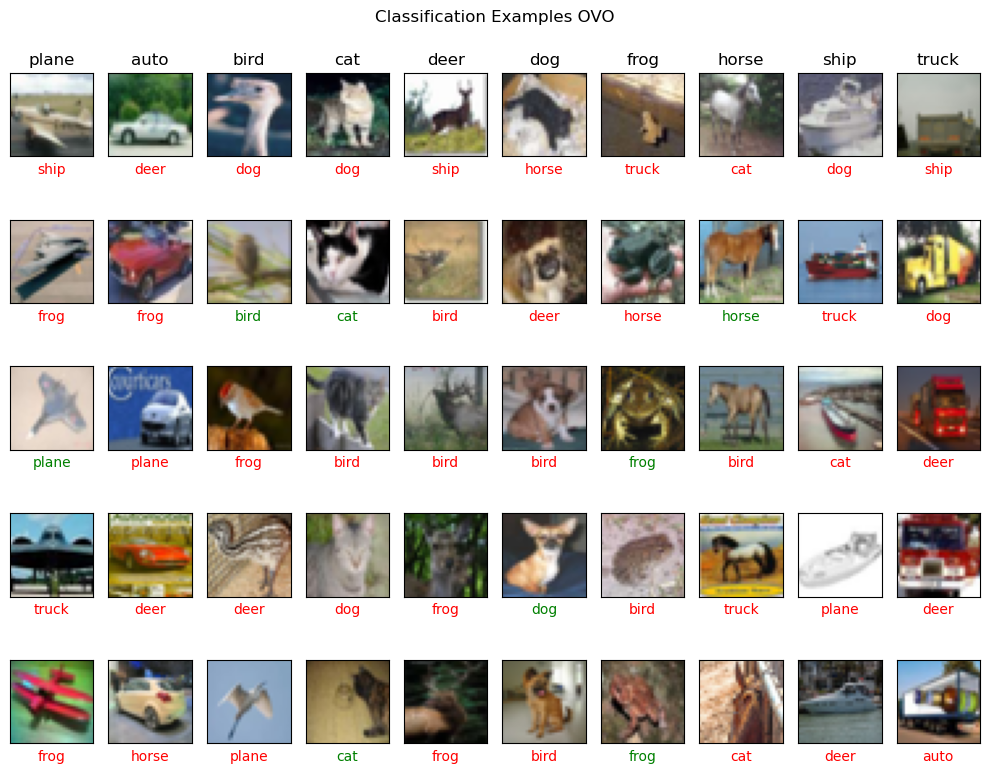

(array([0.395, 0.127, 0.225, 0.169, 0.386, 0.232, 0.449, 0.198, 0.59 ,
        0.318]),
 array([0.41976621, 0.396875  , 0.2245509 , 0.24743777, 0.25394737,
        0.38032787, 0.25849165, 0.35675676, 0.33220721, 0.37149533]),
 array([0.4070067 , 0.19242424, 0.22477522, 0.20083185, 0.30634921,
        0.28819876, 0.32809646, 0.25466238, 0.42507205, 0.34267241]))

In [234]:
# evaluate_model(ovorbfnn,Xval,Yval,'OVO',label,X_test,whoim='rand')

In [208]:
# ovrrbfnn = RBFnn(binary_classifiers,40)
# ovrrbfnn.fit(X_ap,y_ap)

50000 out of 50000

Fitting 1 out of 10
Epoch 1 out of 2.
train loss = 31068.18955	 train acc = 68.93


Epoch 2 out of 2.
train loss = 30930.28904	 train acc = 69.07


Fitting 2 out of 10
Epoch 1 out of 2.
train loss = 18693.40580	 train acc = 81.31


Epoch 2 out of 2.
train loss = 18727.48135	 train acc = 81.28


Fitting 3 out of 10
Epoch 1 out of 2.
train loss = 45820.24144	 train acc = 54.18


Epoch 2 out of 2.
train loss = 45636.27240	 train acc = 54.37


Fitting 4 out of 10
Epoch 1 out of 2.
train loss = 33128.46923	 train acc = 66.87


Epoch 2 out of 2.
train loss = 33160.44989	 train acc = 66.84


Fitting 5 out of 10
Epoch 1 out of 2.
train loss = 42721.13058	 train acc = 57.28


Epoch 2 out of 2.
train loss = 41901.06889	 train acc = 58.10


Fitting 6 out of 10
Epoch 1 out of 2.
train loss = 26320.73216	 train acc = 73.68


Epoch 2 out of 2.
train loss = 26176.74271	 train acc = 73.83

Fitting 7 out of 10
Epoch 1 out of 2.
train loss = 48415.63174	 train acc = 51.59


Epoch 2 o

10000 out of 10000

Prediction time elapsed: 501.14 ms.
Accuracy: 0.3123
              plane      auto      bird       cat     deer       dog      frog     horse      ship     truck   average
recall     0.413000  0.152000  0.194000  0.176000  0.35100  0.246000  0.475000  0.229000  0.525000  0.362000  0.312300
precision  0.436114  0.383838  0.232614  0.240437  0.26692  0.368816  0.257732  0.331404  0.330396  0.367140  0.321541
f1         0.424242  0.217765  0.211559  0.203233  0.30324  0.295141  0.334154  0.270846  0.405562  0.364552  0.303029


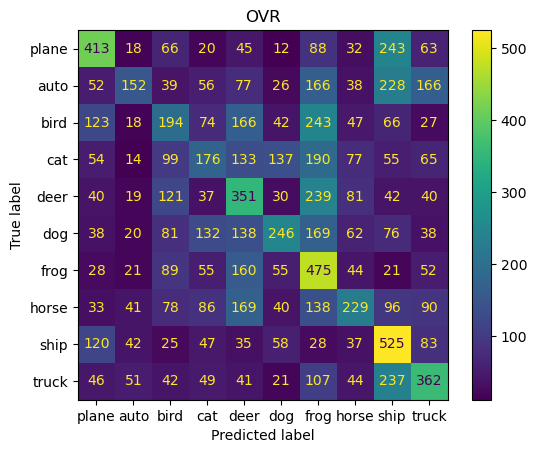

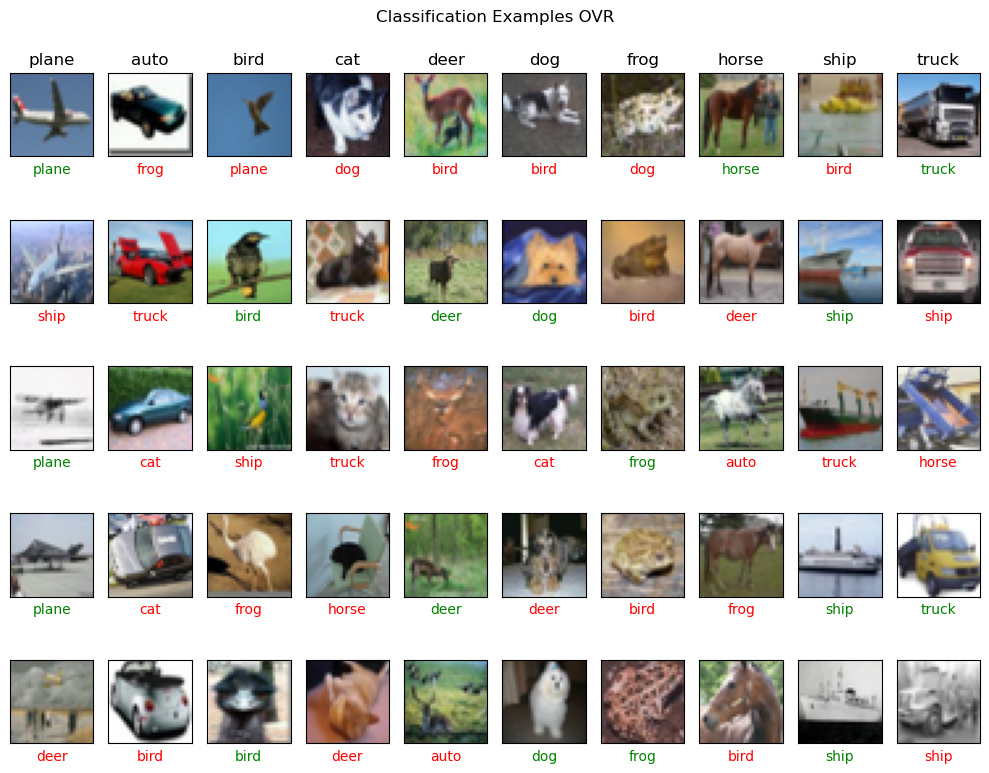

(array([0.413, 0.152, 0.194, 0.176, 0.351, 0.246, 0.475, 0.229, 0.525,
        0.362]),
 array([0.43611404, 0.38383838, 0.23261391, 0.24043716, 0.26692015,
        0.36881559, 0.25773196, 0.33140376, 0.33039648, 0.36713996]),
 array([0.42424242, 0.21776504, 0.21155943, 0.20323326, 0.30323974,
        0.29514097, 0.33415406, 0.27084565, 0.40556199, 0.36455186]))

In [209]:
# evaluate_model(ovrrbfnn,Xval,Yval,'OVR',label,X_test,whoim='rand')